In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from pygam import GAM, s, f, te, l

### Functions

In [2]:
def centralize_data(data, col):
    wm = lambda x: np.average(x, weights = data.loc[x.index, 'PA'])
    cols = ['IDfg', 'Season', 'Name', 'Age', 'PA', 'experience'] + [col]
    df = data.loc[:, cols]

    mean_results = df.groupby(['Season']).agg(weighted_mean = (col, wm))
    mean_results = mean_results.reset_index()
    df = df.merge(mean_results, on = 'Season')
    df[col + '_centralized'] = np.subtract(df[col], df['weighted_mean'])

    return df

In [3]:
def add_career_mean(data, col):
    cols = ['IDfg', 'Season', 'Name', 'Age', 'G', 'PA', 'experience'] + [col, col + '_lag']
    df = data.loc[:, cols]
    wm = lambda x: np.average(x, weights = df.loc[x.index, 'PA'])

    mean_result = df.groupby(['IDfg']).agg(weighted_mean = (col, wm))
    mean_result = mean_result.reset_index()
    mean_result.columns = ['IDfg', col + '_career_mean']
    df = df.merge(mean_result, on = 'IDfg', how = 'left')

    return df

In [4]:
def add_experience(data):
    tmp_df = data.groupby(['IDfg'])
    data['experience'] = tmp_df['Season'].diff().fillna(0.0)
    data['experience'] = data.groupby(['IDfg'])['experience'].cumsum()

    return data

In [5]:
def add_lag(data, col):
    tmp_df = data.groupby(['IDfg'])
    data[col + '_lag'] = tmp_df[col].shift(1)
    data = data.dropna()

    return data

In [6]:
def load_data(target, centralized = False):
    train_data = pd.read_csv('./data/hitter_train_data.csv')
    test_data = pd.read_csv('./data/hitter_test_data.csv')
    
    train_data = train_data.loc[(train_data['Age'] >= 20).values & (train_data['Age'] <= 40).values, :]
    test_data = test_data.loc[(test_data['Age'] >= 20).values & (test_data['Age'] <= 40).values, :]

    train_data = train_data.sort_values(by = ['Season', 'Name']).reset_index(drop = True)
    test_data = test_data.sort_values(by = ['Season', 'Name']).reset_index(drop = True)

    all_data = pd.concat([train_data, test_data])
    all_data = all_data.reset_index(drop = True)
    all_data = add_experience(all_data)
    
    if centralized:
        all_data = centralize_data(all_data, target)
        all_data = add_lag(all_data, col = target + '_centralized')
    else:
        all_data = add_lag(all_data, col = target)

    train_data = all_data.loc[all_data['Season'] < 2020, :]
    test_data = all_data.loc[all_data['Season'] > 2020, :]

    return train_data, test_data

In [7]:
def generate_data(data, feature_cols, target):
    x = data.loc[:, feature_cols].values
    y = data[target].values

    return x, y

In [8]:
def generate_test_data(train_data, test_data, col):
    train_cols = ['IDfg', col + '_career_mean']
    test_cols = ['IDfg', 'Season', "Name", 'Age', 'G', 'PA', 'experience', col + '_lag', col]

    train_df = train_data.loc[:, train_cols]
    train_df = train_df.drop_duplicates()
    test_df = test_data.loc[:, test_cols]

    all_test_data = test_df.merge(train_df, on = 'IDfg', how = 'left')
    all_test_data = all_test_data.dropna()
    all_test_data = all_test_data.reset_index(drop = True)
    
    return all_test_data

In [9]:
def evaluate(data, target, model):
    feature_cols = ['Age', target + '_career_mean', 'experience', target + '_lag']
    test_x, test_y = generate_data(data, feature_cols, target)
    y_preds = model.predict(test_x)
    mae_result = mean_absolute_error(test_y, y_preds, sample_weight = data['PA'].values)

    return mae_result

In [10]:
def inference(data, target, model):
    inference_df = data.copy()
    feature_cols = ['Age', target + '_career_mean', 'experience', target + '_lag']
    test_x, test_y = generate_data(data, feature_cols, target)
    y_preds = model.predict(test_x)
    inference_df['prediction'] = y_preds

    return inference_df

### OPS Aging Curve

In [10]:
train_data, test_data = load_data(target = 'OPS', centralized = True)

In [11]:
print(train_data.shape)
print(test_data.shape)

(13636, 10)
(1463, 10)


In [12]:
ops_data = add_career_mean(train_data, 'OPS_centralized')
ops_data.head()

,IDfg,Season,Name,Age,PA,experience,OPS_centralized,OPS_centralized_lag,OPS_centralized_career_mean
0,1001649,1981,Al Bumbry,34,451,1.0,-0.013428,0.095313,-0.062347
1,1002689,1981,Al Cowens,29,284,1.0,-0.041428,-0.045687,0.000637
2,1009773,1981,Al Oliver,34,448,1.0,0.050572,0.108313,0.051368
3,1014234,1981,Al Woods,27,317,1.0,-0.108428,0.114313,-0.098232
4,1000336,1981,Alan Ashby,29,296,1.0,0.016572,-0.064687,0.000836


In [13]:
features = ['Age', 'OPS_centralized_career_mean', 'experience', 'OPS_centralized_lag']
target = 'OPS_centralized'

x, y = generate_data(ops_data, feature_cols = features, target = target)

In [14]:
gam = GAM(te(0, 2, n_splines = 5, lam = 10) + s(1, n_splines = 5, lam = 10) + s(3, n_splines = 5, lam = 10))
gam.fit(x, y, weights = ops_data['PA'].values)
gam.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     19.5406
Link Function:                     IdentityLink Log Likelihood:                              -1515765.1457
Number of Samples:                        13636 AIC:                                          3031571.3727
                                                AICc:                                         3031571.4376
                                                GCV:                                                1.9276
                                                Scale:                                              1.9226
                                                Pseudo R-Squared:                                   0.6068
Feature Function                  Lam

C:\Users\citioplab\AppData\Local\Temp\ipykernel_44636\2232424398.py:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [15]:
age_lag_means = ops_data.groupby(['Age'])['OPS_centralized_lag'].mean()

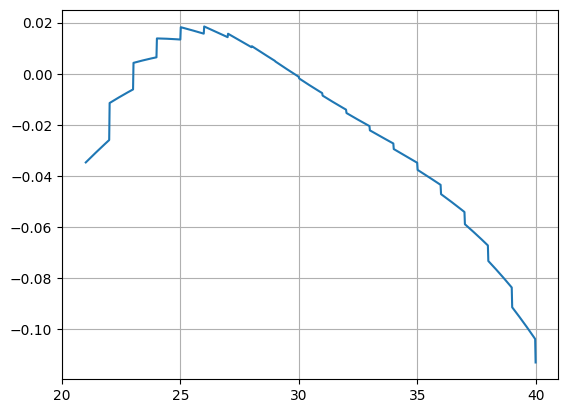

In [16]:
plt.figure()
XX = gam.generate_X_grid(term = 0, n = 1000)
XX[:, 2] = np.subtract(np.floor(XX[:, 0]), 20.0)

for i in range(21, 41):
    tmp = [age_lag_means[x] for x in np.floor(XX[:, 0])]
XX[:, 3] = tmp

plt.plot(XX[:, 0], gam.predict(XX))
plt.xticks(np.arange(20, 45, 5))
plt.grid(True)
plt.show()
# plt.plot(XX[:, 0], gam.partial_dependence(term = 0, X = XX,   width = .95)[1], c = 'r', ls = '--')

In [17]:
np.max(gam.predict(XX))

0.01851217318171569

In [18]:
XX[np.argmax(gam.predict(XX)), 0]

26.002002002002

In [19]:
all_test_data = generate_test_data(ops_data, test_data, 'OPS_centralized')
all_test_data.shape

(785, 9)

In [20]:
all_test_data.head()

,IDfg,Season,Name,Age,PA,experience,OPS_centralized_lag,OPS_centralized,OPS_centralized_career_mean
0,9256,2021,A.J. Pollock,33,422,8.0,0.016220,0.144419,0.074625
1,5297,2021,Aaron Hicks,31,126,8.0,-0.009780,-0.120581,-0.002902
2,15640,2021,Aaron Judge,29,633,4.0,0.142220,0.168419,0.158497
3,5486,2021,Abraham Almonte,32,175,7.0,-0.201894,-0.017581,-0.082472
4,13769,2021,Adalberto Mondesi,25,136,5.0,-0.063780,-0.024581,-0.015457


In [21]:
evaluate(all_test_data, 'OPS_centralized', gam)

0.0752545987331969

In [22]:
ops_mean = np.average(train_data['OPS'].values, weights = train_data['PA'].values)
print(ops_mean)

0.7607377766085469


In [23]:
(0.0752545987331969 / ops_mean) * 100

9.892317832392946

### wRC+ Aging Curve

In [24]:
train_data, test_data = load_data(target = 'wRC+')
print(train_data.shape)
print(test_data.shape)

(13540, 22)
(1452, 22)


In [25]:
wrc_data = add_career_mean(train_data, 'wRC+')
wrc_data.head()

,IDfg,Season,Name,Age,PA,experience,wRC+,wRC+_lag,wRC+_career_mean
0,1001649,1981,Al Bumbry,34,451,1.0,107,131.0,88.126911
1,1002689,1981,Al Cowens,29,284,1.0,91,87.0,96.489462
2,1009773,1981,Al Oliver,34,448,1.0,118,130.0,117.817251
3,1014234,1981,Al Woods,27,317,1.0,63,127.0,65.490775
4,1000336,1981,Alan Ashby,29,296,1.0,113,86.0,108.320983


In [26]:
features = ['Age', 'wRC+_career_mean', 'experience', 'wRC+_lag']
target = 'wRC+'

x, y = generate_data(wrc_data, feature_cols = features, target = target)

In [27]:
gam = GAM(te(0, 2, n_splines = 5, lam = 10) + s(1, n_splines = 5, lam = 10) + s(3, n_splines = 5, lam = 10))
gam.fit(x, y, weights = wrc_data['PA'].values)
gam.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     19.2615
Link Function:                     IdentityLink Log Likelihood:                                -92142.1695
Number of Samples:                        13540 AIC:                                            184324.862
                                                AICc:                                          184324.9257
                                                GCV:                                           131335.5346
                                                Scale:                                         130999.2781
                                                Pseudo R-Squared:                                   0.6007
Feature Function                  Lam

C:\Users\citioplab\AppData\Local\Temp\ipykernel_44636\1497089973.py:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [28]:
age_lag_means = wrc_data.groupby(['Age'])['wRC+_lag'].mean()

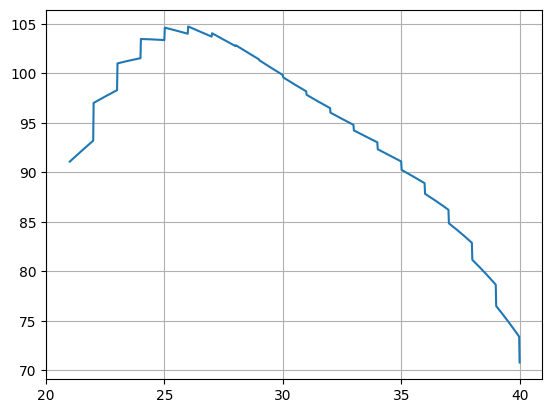

In [29]:
plt.figure()
XX = gam.generate_X_grid(term = 0, n = 1000)
XX[:, 1] = 100
XX[:, 2] = np.subtract(np.floor(XX[:, 0]), 20.0)

for i in range(21, 41):
    tmp = [age_lag_means[x] for x in np.floor(XX[:, 0])]
XX[:, 3] = tmp

plt.plot(XX[:, 0], gam.predict(XX))
plt.xticks(np.arange(20, 45, 5))
plt.grid(True)
plt.show()
# plt.plot(XX[:, 0], gam.partial_dependence(term = 0, X = XX,   width = .95)[1], c = 'r', ls = '--')

In [30]:
np.max(gam.predict(XX))

104.72882387376886

In [31]:
XX[np.argmax(gam.predict(XX)), 0]

26.002002002002

In [32]:
all_test_data = generate_test_data(wrc_data, test_data, 'wRC+')

In [33]:
all_test_data.head()

,IDfg,Season,Name,Age,PA,experience,wRC+_lag,wRC+,wRC+_career_mean
0,9256,2021,A.J. Pollock,33,422,8.0,107.0,137,117.510323
1,5297,2021,Aaron Hicks,31,126,8.0,103.0,77,104.298665
2,15640,2021,Aaron Judge,29,633,4.0,141.0,150,145.742857
3,5486,2021,Abraham Almonte,32,175,7.0,48.0,98,78.063910
4,13769,2021,Adalberto Mondesi,25,136,5.0,81.0,89,93.686649


In [34]:
evaluate(all_test_data, 'wRC+', gam)

19.489687780658297

In [50]:
pred_df = inference(all_test_data, 'wRC+', gam)
pred_df.head(10)

,IDfg,Season,Name,Age,PA,experience,wRC+_lag,wRC+,wRC+_career_mean,prediction
0,9256,2021,A.J. Pollock,33,422,8.0,107.0,137,117.510323,113.836819
1,5297,2021,Aaron Hicks,31,126,8.0,103.0,77,104.298665,103.060653
2,15640,2021,Aaron Judge,29,633,4.0,141.0,150,145.742857,148.037785
3,5486,2021,Abraham Almonte,32,175,7.0,48.0,98,78.063910,78.426255
4,13769,2021,Adalberto Mondesi,25,136,5.0,81.0,89,93.686649,98.589820
5,10950,2021,Adam Duvall,32,555,5.0,120.0,101,89.015781,87.884563
6,11205,2021,Adam Eaton,32,288,9.0,108.0,68,114.373018,111.709700
7,15082,2021,Adam Engel,29,140,4.0,83.0,125,73.232068,74.080895
8,15223,2021,Adam Frazier,29,639,5.0,97.0,113,101.729844,103.420457
9,6310,2021,Alcides Escobar,34,349,12.0,59.0,102,69.824946,64.128508


When analyzing the MAE performance of the aging curves for OPS and wRC+, it is evident that GAM is the superior method. Besides, both the delta method and GAM estimates that hitters reach their peak performance at age 26.<br>
Both methods point to a dramatic decline in a batter's hitting ability after age 35, but the delta method suggests that batters ultimately decline to worse performances. In addition, wRC+ is a much more difficult metric to predict, given the performance of these two methods. <br>
Moreover, reaching their peak at 26 seems earlier than expected, as many believe athletes peak at 27 or 28.

### Def Aging Curve

In [48]:
train_data, test_data = load_data(target = 'Def')
print(train_data.shape)
print(test_data.shape)

(13540, 22)
(1452, 22)


In [49]:
def_data = add_career_mean(train_data, 'Def')
def_data.head()

,IDfg,Season,Name,Age,G,PA,experience,Def,Def_lag,Def_career_mean
0,1001649,1981,Al Bumbry,34,101,451,1.0,-10.0,2.0,-0.458053
1,1002689,1981,Al Cowens,29,85,284,1.0,0.4,-7.1,-7.917935
2,1009773,1981,Al Oliver,34,102,448,1.0,-10.9,-14.3,-14.632651
3,1014234,1981,Al Woods,27,85,317,1.0,2.4,-3.3,-0.339852
4,1000336,1981,Alan Ashby,29,83,296,1.0,9.6,1.3,-1.625614


In [50]:
features = ['Age', 'Def_career_mean', 'experience', 'Def_lag']
target = 'Def'

x, y = generate_data(def_data, feature_cols = features, target = target)

In [51]:
gam = GAM(te(0, 2, n_splines = 5, lam = 10) + s(1, n_splines = 5, lam = 10) + s(3, n_splines = 5, lam = 10))
gam.fit(x, y, weights = def_data['G'].values)
gam.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     16.8337
Link Function:                     IdentityLink Log Likelihood:                                -63115.9164
Number of Samples:                        13540 AIC:                                           126267.5003
                                                AICc:                                            126267.55
                                                GCV:                                             4377.1914
                                                Scale:                                           4367.3969
                                                Pseudo R-Squared:                                   0.5885
Feature Function                  Lam

C:\Users\citioplab\AppData\Local\Temp\ipykernel_76676\1717189650.py:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [52]:
age_lag_means = def_data.groupby(['Age'])['Def_lag'].mean()

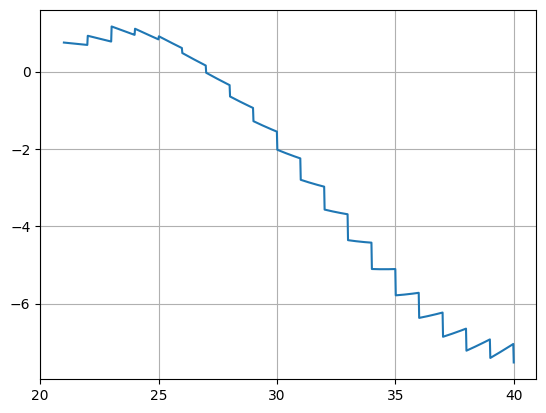

In [53]:
plt.figure()
XX = gam.generate_X_grid(term = 0, n = 1000)
XX[:, 1] = np.mean(def_data['Def'])
XX[:, 2] = np.subtract(np.floor(XX[:, 0]), 20.0)

for i in range(21, 41):
    tmp = [age_lag_means[x] for x in np.floor(XX[:, 0])]
XX[:, 3] = tmp

plt.plot(XX[:, 0], gam.predict(XX))
plt.xticks(np.arange(20, 45, 5))
plt.grid(True)
plt.show()
# plt.plot(XX[:, 0], gam.partial_dependence(term = 0, X = XX,   width = .95)[1], c = 'r', ls = '--')

In [54]:
np.max(gam.predict(XX))

1.1640894816084626

In [55]:
XX[np.argmax(gam.predict(XX)), 0]

23.016016016016017

In [56]:
all_test_data = generate_test_data(def_data, test_data, 'Def')

In [57]:
all_test_data.head()

,IDfg,Season,Name,Age,G,PA,experience,Def_lag,Def,Def_career_mean
0,9256,2021,A.J. Pollock,33,117,422,8.0,-9.5,-3.5,2.908528
1,5297,2021,Aaron Hicks,31,32,126,8.0,-3.0,0.1,-0.200000
2,15640,2021,Aaron Judge,29,148,633,4.0,3.7,-6.0,3.647302
3,5486,2021,Abraham Almonte,32,64,175,7.0,-4.0,-4.8,-0.679449
4,13769,2021,Adalberto Mondesi,25,35,136,5.0,12.0,3.7,9.938420


In [58]:
evaluate(all_test_data, 'Def', gam)

4.6427235702810625

In [59]:
pred_df = inference(all_test_data, 'Def', gam)
pred_df.head(10)

,IDfg,Season,Name,Age,G,PA,experience,Def_lag,Def,Def_career_mean,prediction
0,9256,2021,A.J. Pollock,33,117,422,8.0,-9.5,-3.5,2.908528,0.869301
1,5297,2021,Aaron Hicks,31,32,126,8.0,-3.0,0.1,-0.200000,-1.318423
2,15640,2021,Aaron Judge,29,148,633,4.0,3.7,-6.0,3.647302,3.971776
3,5486,2021,Abraham Almonte,32,64,175,7.0,-4.0,-4.8,-0.679449,-1.682800
4,13769,2021,Adalberto Mondesi,25,35,136,5.0,12.0,3.7,9.938420,11.495793
5,10950,2021,Adam Duvall,32,146,555,5.0,2.0,5.2,6.162458,5.428717
6,11205,2021,Adam Eaton,32,84,288,9.0,-10.9,-5.5,-0.142596,-2.195360
7,15082,2021,Adam Engel,29,39,140,4.0,4.3,2.8,8.858368,8.730849
8,15223,2021,Adam Frazier,29,155,639,5.0,9.3,1.6,1.854173,2.748063
9,6310,2021,Alcides Escobar,34,75,349,12.0,-3.1,1.6,10.299173,5.893605


The peak of a player's defensive abilities is reached around the age of 23, which is earlier than the peak of hitting ability at 26. This means that a player's defensive abilities will start to decline earlier. Therefore, teams should exercise caution when signing free agents primarily known for their defensive skills. Additionally, this indicates that developing a player's defensive ability is challenging, implying that talent and physical attributes play a significant role.

### Spd Aging Curve

In [11]:
train_data, test_data = load_data(target = 'Spd')
print(train_data.shape)
print(test_data.shape)

(13540, 22)
(1452, 22)


In [12]:
spd_data = add_career_mean(train_data, 'Spd')
spd_data.head()

,IDfg,Season,Name,Age,G,PA,experience,Spd,Spd_lag,Spd_career_mean
0,1001649,1981,Al Bumbry,34,101,451,1.0,5.5,7.3,5.253262
1,1002689,1981,Al Cowens,29,85,284,1.0,4.6,3.7,4.549075
2,1009773,1981,Al Oliver,34,102,448,1.0,3.7,3.2,2.869988
3,1014234,1981,Al Woods,27,85,317,1.0,2.0,3.5,2.290590
4,1000336,1981,Alan Ashby,29,83,296,1.0,0.9,1.9,1.503665


In [14]:
features = ['Age', 'Spd_career_mean', 'experience', 'Spd_lag']
target = 'Spd'

x, y = generate_data(spd_data, feature_cols = features, target = target)

In [15]:
gam = GAM(te(0, 2, n_splines = 5, lam = 10) + s(1, n_splines = 5, lam = 10) + s(3, n_splines = 5, lam = 10))
gam.fit(x, y, weights = spd_data['G'].values)
gam.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     17.5831
Link Function:                     IdentityLink Log Likelihood:                                -19176.9857
Number of Samples:                        13540 AIC:                                            38391.1378
                                                AICc:                                           38391.1916
                                                GCV:                                               94.4545
                                                Scale:                                             94.2337
                                                Pseudo R-Squared:                                   0.7341
Feature Function                  Lam

C:\Users\citioplab\AppData\Local\Temp\ipykernel_14792\3273327353.py:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [18]:
age_lag_means = spd_data.groupby(['Age'])['Spd_lag'].mean()

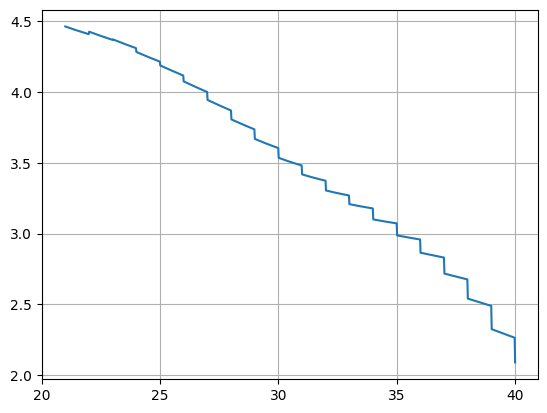

In [19]:
plt.figure()
XX = gam.generate_X_grid(term = 0, n = 1000)
XX[:, 1] = np.mean(spd_data['Spd'])
XX[:, 2] = np.subtract(np.floor(XX[:, 0]), 20.0)

for i in range(21, 41):
    tmp = [age_lag_means[x] for x in np.floor(XX[:, 0])]
XX[:, 3] = tmp

plt.plot(XX[:, 0], gam.predict(XX))
plt.xticks(np.arange(20, 45, 5))
plt.grid(True)
plt.show()
# plt.plot(XX[:, 0], gam.partial_dependence(term = 0, X = XX,   width = .95)[1], c = 'r', ls = '--')

In [21]:
np.mean(spd_data['Spd'])

3.9044534711964554

In [20]:
np.max(gam.predict(XX))

4.464105885660717

In [22]:
XX[np.argmax(gam.predict(XX)), 0]

21.0

In [23]:
all_test_data = generate_test_data(spd_data, test_data, 'Spd')

In [24]:
all_test_data.head()

,IDfg,Season,Name,Age,G,PA,experience,Spd_lag,Spd,Spd_career_mean
0,9256,2021,A.J. Pollock,33,117,422,8.0,4.9,4.4,6.853546
1,5297,2021,Aaron Hicks,31,32,126,8.0,2.7,1.3,4.240727
2,15640,2021,Aaron Judge,29,148,633,4.0,3.6,2.9,3.283810
3,5486,2021,Abraham Almonte,32,64,175,7.0,5.3,2.3,6.676692
4,13769,2021,Adalberto Mondesi,25,35,136,5.0,9.0,8.6,8.841417


In [25]:
evaluate(all_test_data, 'Spd', gam)

0.9671764042853446

In [26]:
pred_df = inference(all_test_data, 'Spd', gam)
pred_df.head(10)

,IDfg,Season,Name,Age,G,PA,experience,Spd_lag,Spd,Spd_career_mean,prediction
0,9256,2021,A.J. Pollock,33,117,422,8.0,4.9,4.4,6.853546,6.262724
1,5297,2021,Aaron Hicks,31,32,126,8.0,2.7,1.3,4.240727,3.845641
2,15640,2021,Aaron Judge,29,148,633,4.0,3.6,2.9,3.283810,3.344654
3,5486,2021,Abraham Almonte,32,64,175,7.0,5.3,2.3,6.676692,6.248797
4,13769,2021,Adalberto Mondesi,25,35,136,5.0,9.0,8.6,8.841417,9.068486
5,10950,2021,Adam Duvall,32,146,555,5.0,2.8,4.2,3.320183,3.158991
6,11205,2021,Adam Eaton,32,84,288,9.0,6.5,6.2,6.329674,5.956589
7,15082,2021,Adam Engel,29,39,140,4.0,4.7,5.9,5.807032,5.734918
8,15223,2021,Adam Frazier,29,155,639,5.0,4.8,4.8,4.790240,4.772449
9,6310,2021,Alcides Escobar,34,75,349,12.0,5.0,5.3,6.001492,5.252748


This indicates that a player's base running has decreased since the start of his MLB career. That is to say, the speed of running bases is primarily determined by natural talent. Again, teams should be cautious when signing free agents who are primarily known for their speed.

### WAR Aging Curve

In [11]:
train_data, test_data = load_data(target = 'WAR')
print(train_data.shape)
print(test_data.shape)

(13540, 22)
(1452, 22)


In [12]:
war_data = add_career_mean(train_data, 'WAR')
war_data.head()

,IDfg,Season,Name,Age,G,PA,experience,WAR,WAR_lag,WAR_career_mean
0,1001649,1981,Al Bumbry,34,101,451,1.0,0.7,6.1,0.846381
1,1002689,1981,Al Cowens,29,85,284,1.0,0.6,0.2,0.786667
2,1009773,1981,Al Oliver,34,102,448,1.0,1.3,3.4,1.825994
3,1014234,1981,Al Woods,27,85,317,1.0,-0.2,2.4,-0.407565
4,1000336,1981,Alan Ashby,29,83,296,1.0,2.5,0.8,1.313733


In [13]:
features = ['Age', 'WAR_career_mean', 'experience', 'WAR_lag']
target = 'WAR'

x, y = generate_data(war_data, feature_cols = features, target = target)

In [14]:
gam = GAM(te(0, 2, n_splines = 5, lam = 10) + s(1, n_splines = 5, lam = 10) + s(3, n_splines = 5, lam = 10))
gam.fit(x, y, weights = war_data['G'].values)
gam.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     16.9904
Link Function:                     IdentityLink Log Likelihood:                                -26197.1677
Number of Samples:                        13540 AIC:                                            52430.3162
                                                AICc:                                           52430.3668
                                                GCV:                                              215.1521
                                                Scale:                                            214.6662
                                                Pseudo R-Squared:                                   0.5611
Feature Function                  Lam

C:\Users\citioplab\AppData\Local\Temp\ipykernel_36000\2913956295.py:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [15]:
age_lag_means = war_data.groupby(['Age'])['WAR_lag'].mean()

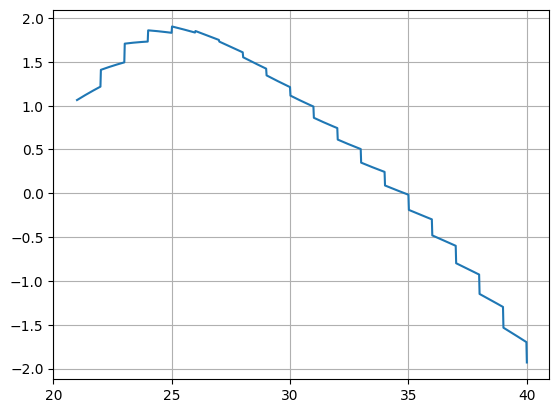

In [16]:
plt.figure()
XX = gam.generate_X_grid(term = 0, n = 1000)
XX[:, 1] = np.mean(war_data['WAR'])
XX[:, 2] = np.subtract(np.floor(XX[:, 0]), 20.0)

for i in range(21, 41):
    tmp = [age_lag_means[x] for x in np.floor(XX[:, 0])]
XX[:, 3] = tmp

plt.plot(XX[:, 0], gam.predict(XX))
plt.xticks(np.arange(20, 45, 5))
plt.grid(True)
plt.show()
# plt.plot(XX[:, 0], gam.partial_dependence(term = 0, X = XX,   width = .95)[1], c = 'r', ls = '--')

In [17]:
np.mean(war_data['WAR'])

1.4684121122599705

In [18]:
np.max(gam.predict(XX))

1.9040903718079083

In [19]:
XX[np.argmax(gam.predict(XX)), 0]

25.013013013013015

In [20]:
all_test_data = generate_test_data(war_data, test_data, 'WAR')

In [21]:
all_test_data.head()

,IDfg,Season,Name,Age,G,PA,experience,WAR_lag,WAR,WAR_career_mean
0,9256,2021,A.J. Pollock,33,117,422,8.0,0.5,3.2,3.438824
1,5297,2021,Aaron Hicks,31,32,126,8.0,0.6,0.1,1.874689
2,15640,2021,Aaron Judge,29,148,633,4.0,4.2,5.5,4.674286
3,5486,2021,Abraham Almonte,32,64,175,7.0,-0.8,-0.1,0.261153
4,13769,2021,Adalberto Mondesi,25,35,136,5.0,2.6,1.0,2.679292


In [22]:
evaluate(all_test_data, 'WAR', gam)

1.472874265005307

In [23]:
pred_df = inference(all_test_data, 'WAR', gam)
pred_df.head(10)

,IDfg,Season,Name,Age,G,PA,experience,WAR_lag,WAR,WAR_career_mean,prediction
0,9256,2021,A.J. Pollock,33,117,422,8.0,0.5,3.2,3.438824,2.827177
1,5297,2021,Aaron Hicks,31,32,126,8.0,0.6,0.1,1.874689,1.518482
2,15640,2021,Aaron Judge,29,148,633,4.0,4.2,5.5,4.674286,4.989498
3,5486,2021,Abraham Almonte,32,64,175,7.0,-0.8,-0.1,0.261153,-0.093308
4,13769,2021,Adalberto Mondesi,25,35,136,5.0,2.6,1.0,2.679292,3.201168
5,10950,2021,Adam Duvall,32,146,555,5.0,1.0,2.3,1.665282,1.521952
6,11205,2021,Adam Eaton,32,84,288,9.0,2.0,-0.6,3.317559,2.796420
7,15082,2021,Adam Engel,29,39,140,4.0,0.8,1.4,0.995359,1.113994
8,15223,2021,Adam Frazier,29,155,639,5.0,2.6,3.3,1.879915,2.109554
9,6310,2021,Alcides Escobar,34,75,349,12.0,-0.9,1.4,1.348994,0.217593


Position players typically reach the peak of their overall contribution around the age of 25. Simiarly, the contribution of position players tends to decline significantly after the age of 35. Therefore, when signing a long-term contract lasting over 10 years, a team should consider whether the player's contributions in the early years of the contract will offset any decline in performance that may occur later on.